In [1]:
%load_ext autoreload
%autoreload 2

import random, glob, json
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
from pathlib import Path
# import pyarrow.dataset as ds
# import pyarrow as pa
# import networkx as nx

from tqdm import tqdm

from rdkit.Chem import PandasTools as pdt
from rdkit import Chem
from rdkit import DataStructs
tqdm.pandas()
from rdkit.Chem import QED

# import plip
# import matplotlib.pyplot as plt


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
import requests
import gemmi 
import os
from __future__ import annotations

def load_ccd_via_gemmi(basedir: Path | None = None) -> Any:
    if basedir is None:
        basedir = Path(__file__).parent.absolute()
    
    chem_dict_path = basedir / "artifacts"
    chem_dict_path.mkdir(exist_ok=True, parents=True)
    chem_dict_path = chem_dict_path / "components.cif"
    if not chem_dict_path.exists():
        url = "https://files.wwpdb.org/pub/pdb/data/monomers/components.cif"
        r = requests.get(url, allow_redirects=True)
        with open(chem_dict_path, "wb") as out:
            out.write(r.content)
    return gemmi.cif.read_file(str(chem_dict_path))

def get_ccd_smiles_dict(ciffile: str) -> Dict[str, str]:
    # Tiny funcs to loop over only required information:
    assert os.path.exists(ciffile), "failed to find {ciffile} file."
    ccd = gemmi.cif.read_file(ciffile)
    smidict = {}
    for m in tqdm(ccd):
        keys = m.find_loop("_pdbx_chem_comp_descriptor.program")
        keys2 = m.find_loop("_pdbx_chem_comp_descriptor.type")
        values = m.find_loop("_pdbx_chem_comp_descriptor.descriptor")

        for k, k2, v in zip(keys, keys2, values):
            if ("CANONICAL" in k2) and ("OpenEye" in k):
                smidict[str(m.name).upper()] = v.strip('"').strip(';')
                break
    return smidict


def parse_cofactors() -> set[str]:
    """Download and parse cofactors.

    Returns
    -------
    Set[str]
        Set of cofactors

    """
    cofactors_json = requests.get(
        "https://www.ebi.ac.uk/pdbe/api/pdb/compound/cofactors"
    ).json()
    extra = {
        "Ascorbic acid": ["UU3"],
        "Coenzyme F420": ["6J4", "F42"],
        "Factor F430": ["F43", "M43"],
        "Pantetheine": ["PNY"],
        "Pantothenic acids": ["66S", "8Q1", "PAU"],
        "Nicotinamide": ["NCA"],
        "Adenosine nucleotides": ["AMP", "ATP", "ADP"] + ["ANP"],  #TODO: check!
        "Guanosine nucleotides": ["GTP", "GDP"] + ["GMP", "GNP"],  #TODO: check!
        "other mononucleotides": ["A", "T", "G", "C", "U", "TMP", "UMP"], #+ ['CMP']
        "other dinucleotides": ["CDP", "TDP", "UDP"],   #TODO: check!
        "other trinucleotides": ["CTP", "TTP", "UTP"],  #TODO: check!
        "Tetrahydrofolic acid": ["MEF"],
        "Lumazine": ["DLZ"],
        "Menaquinone": ["MQ8", "MQ9", "MQE"],
        "Heme": ["1CP", "CP3", "MMP", "UP2", "UP3"],
        "Methanopterin": ["H4M", "H4Z"],
        "Lipoamide": ["LPM"],
        "Ubiquinone": ["DCQ", "HQE", "PLQ"],
        "Pyridoxal": ["PXL", "UEG"],
        "Siderophores": ["488", "EB4", "SE8"],
        "Methanofuran": ["MFN"],
        "Vitamin A": ["BCR", "ECH", "EQ3", "RAW"],
        "Vitamin K1": ["PQN"],
        "CHLOROPHYLL and similar": [
            "CLA",
            "CHL",
            "CL0",
            "CL1",
            "CL2",
            "CL7",
            "BCB",
            "BCL",
            "07D",
            "G9R",
            "PEB",
            "PUB",
            "CYC",
            "BPH"
        ],
        # "Lipids": ["SPH"], #TODO: ?
        # "Sugars": ["NAG", "BCG", "GLC"], #TODO: more?
        #
    }
    cofactors = set()
    for c in cofactors_json:
        for c_list in cofactors_json[c]:
            cofactors |= set(c_list.get("cofactors", []))
    for c in extra:
        cofactors |= set(extra[c])
    return cofactors


selection_to_keep = """
NAG
GCP
NDG
A2G
NGA
5AD
THM
GUN
HC4
FOL
DUD
BM3
IBM
TCA
NVP
NUC
III
NAA
NSP
GTT
BTC
FCY
SWE
SUC
LXB
NGZ
LXZ
STO
CLR
CHD
ORO
D01
IPL
STU
KAI
YF3
CB3
SAL
TG1
"""

keep_as_not_artifacts = set(selection_to_keep.strip().split('\n'))

selection_to_ban = """
1PS
2NV
32M
33O
3V3
7I7
90A
9FO
9YU
B4T
B4X
D22
DR6
DRE
F4R
HZA
I3C
JDJ
K12
OP2
OTE
P03
P2K
P4K
PE6
PE7
PQE
PTD
QGT
QJE
QLB
RWB
SP5
TCE
TFA
V1J
Y69
"""

add_as_artifacts = set(selection_to_ban.strip().split('\n'))

# instantiate cofactor list once and reuse variable

COFACTORS = parse_cofactors()


In [3]:
# save

In [4]:
# cofactors_json = requests.get(
#         "https://www.ebi.ac.uk/pdbe/api/pdb/compound/cofactors"
#     ).json()

In [5]:
# extra = {
#         "Lumazine": ["DLZ"],
#         "Menaquinone": ["MQ8", "MQ9", "MQE"],
#         "Heme": ["1CP", "CP3", "MMP", "UP2", "UP3"],
# }

In [6]:
len(COFACTORS)

434

In [7]:
ccd_dict = get_ccd_smiles_dict('/Users/vladas/Projects/test_dump/artifacts/components.cif')

100%|██████████| 43107/43107 [00:00<00:00, 84814.88it/s]


## curate artifacts

In [8]:
df_raw = pd.read_csv('/Users/vladas/Projects/test_dump/data_full_13042024.tsv', sep='\t')

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/649124535.py:1: DtypeWarning: Columns (57,58,92,93,120,130,131,143,145,176,177,178,179,180,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,219,220,221,224,225,226) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/Users/vladas/Projects/test_dump/data_full_13042024.tsv', sep='\t')


In [9]:
df_raw.describe()

/opt/homebrew/Caskroom/mambaforge/base/envs/plinder/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Unnamed: 0,ligand_rscc,ligand_rsr,ligand_owab,ligand_avgoccu,ligand_NatomsEDS,ligand_model,ligand_auth_resnum,ligand_ent,prox_O_lt_.9,...,ligand_mogul_rmsz_numbonds,ligand_mogul_angles_rmsz,ligand_mogul_rmsz_numangles,ligand_ligand_num_symm_clashes,ligand_ligand_num_clashes,ligand_missing_XML_subgroup,ligand_phi,ligand_psi,ligand_flippable-sidechain,ligand_RNAscore
count,2.115643e+06,1.415174e+06,1.415174e+06,1.416228e+06,1.416228e+06,1.416228e+06,1587758.0,1.587758e+06,1.587758e+06,1.587758e+06,...,1.008190e+06,949681.000000,960147.000000,41217.000000,41217.000000,0.0,48.000000,48.000000,130.0,150.000000
mean,4.017833e+02,8.955054e-01,1.927873e-01,5.196153e+01,9.360208e-01,9.234993e+00,1.0,9.514977e+02,1.122020e+01,3.532287e+00,...,1.191660e+01,0.962976,14.648103,0.164350,6.883058,NaN,-78.368750,101.872917,1.0,0.000133
std,6.435396e+02,1.137326e-01,1.481995e-01,3.521001e+01,1.764781e-01,1.310500e+01,0.0,1.201468e+03,2.080414e+01,2.357402e+02,...,1.347691e+01,0.928118,16.743190,2.181156,6.711893,NaN,55.649707,78.972561,0.0,0.001151
min,0.000000e+00,-9.310000e-01,3.000000e-03,-5.980000e+00,0.000000e+00,0.000000e+00,1.0,-4.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,-146.600000,-171.700000,1.0,0.000000
25%,1.040000e+02,8.580000e-01,1.030000e-01,2.812000e+01,1.000000e+00,1.000000e+00,1.0,3.020000e+02,2.000000e+00,0.000000e+00,...,4.000000e+00,0.310000,5.000000,0.000000,3.000000,NaN,-109.525000,104.375000,1.0,0.000000
50%,2.110000e+02,9.310000e-01,1.590000e-01,4.440000e+01,1.000000e+00,5.000000e+00,1.0,5.010000e+02,3.000000e+00,0.000000e+00,...,5.000000e+00,0.690000,6.000000,0.000000,5.000000,NaN,-84.800000,130.100000,1.0,0.000000
75%,3.880000e+02,9.720000e-01,2.390000e-01,6.643000e+01,1.000000e+00,1.000000e+01,1.0,1.007000e+03,5.000000e+00,0.000000e+00,...,1.600000e+01,1.400000,19.000000,0.000000,8.000000,NaN,-67.350000,148.300000,1.0,0.000000
max,5.797000e+03,1.000000e+00,6.786000e+00,9.866900e+02,2.710000e+00,3.090000e+02,1.0,9.999000e+03,9.600000e+01,1.801930e+05,...,1.680000e+02,42.100000,256.000000,109.000000,107.000000,NaN,153.800000,173.000000,1.0,0.010000


In [10]:
df_raw.head(2)

,Unnamed: 0,validation_pocket_ID,ligand_rscc,ligand_rsr,ligand_owab,ligand_avgoccu,ligand_NatomsEDS,ligand_mogul-ignore,ligand_model,ligand_auth_chain,...,ligand_psi,ligand_rama,ligand_plane-outlier.planeRMSD,ligand_plane-outlier.type,ligand_flippable-sidechain,ligand_RNAscore,ligand_RNAsuite,ligand_bond-outlier.link,ligand_angle-outlier.link,system_pass_validation_criteria
0,0,4WIF__C__ZN,0.990,0.031,12.06,1.0,1.0,yes,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass
1,1,4WIF__D__ZN,0.996,0.017,11.97,1.0,1.0,yes,1.0,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass


In [11]:
df_raw[['ligand_ccd_code_x', 'ligand_ccd_code_y', 'ligand_ccd_code']].isna().sum()

ligand_ccd_code_x     565907
ligand_ccd_code_y     512794
ligand_ccd_code      1644616
dtype: int64

In [12]:
df_raw['ccd_code'] = [{v for v in vals if v == v} for vals in df_raw[['ligand_ccd_code_x', 'ligand_ccd_code_y', 'ligand_ccd_code']].values]

In [13]:
df_raw[df_raw['ccd_code'].apply(lambda x: len(x) > 1)]

,Unnamed: 0,validation_pocket_ID,ligand_rscc,ligand_rsr,ligand_owab,ligand_avgoccu,ligand_NatomsEDS,ligand_mogul-ignore,ligand_model,ligand_auth_chain,...,ligand_rama,ligand_plane-outlier.planeRMSD,ligand_plane-outlier.type,ligand_flippable-sidechain,ligand_RNAscore,ligand_RNAsuite,ligand_bond-outlier.link,ligand_angle-outlier.link,system_pass_validation_criteria,ccd_code


## get more info on chains from .json file

In [14]:
#!gsutil -m cp  gs://plinder-collab-bucket/all_entries.json ../test_dump/
df_json = pd.read_json('/Users/vladas/Projects/test_dump/all_entries.json')

In [15]:
len(df_json)

213449

In [16]:
def get_Pfams_set_from_entry(chains, ligand_like_chains):
    receptor_chains = set(chains).difference(ligand_like_chains)
    pfam_list = []
    if len(receptor_chains):
        for chain_id in chains:
            pfam_list += chains[chain_id].get('mappings', []).get('Pfam', [])
    return tuple(set(pfam_list))

In [17]:
# sys0['1fb7__1__1.A_2.A__1.B']['ligands'][0]['interacting_residues'] #.keys()

In [18]:
df_json['receptor_chains_per_pdb'] = [len(set(chs).difference(llchs))
                                      for chs, llchs in
                                      tqdm(df_json[['chains', 'ligand_like_chains']].values)
                                      ]


100%|██████████| 213449/213449 [00:00<00:00, 749601.44it/s]


In [19]:
df_json['Pfams_set'] = [get_Pfams_set_from_entry(chs, llchs)
                        for chs, llchs in
                        df_json[['chains', 'ligand_like_chains']].values
                        ]

In [20]:
df_json.head(2).Pfams_set.loc[0]

('PF00077',)

In [21]:
df_full = df_raw.merge(df_json[['pdb_id', 'receptor_chains_per_pdb', 'Pfams_set']],
                left_on='system_pdb_id',
                right_on='pdb_id',
                how='left'
                )

In [22]:
df_full['receptor_chains_per_pdb'].isna().sum()

0

In [23]:
# [c for c in df_full.columns if c.find('pdb') != -1]

In [24]:
# remove empty ones 
df_full_ccd = df_full[df_full['ccd_code'].apply(lambda x: len(x) == 1)]

In [25]:
df_full_ccd['ccd_code'] = df_full_ccd['ccd_code'].apply(lambda x: list(x)[0])

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/3381070645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_ccd['ccd_code'] = df_full_ccd['ccd_code'].apply(lambda x: list(x)[0])


In [26]:
df_full_ccd['num_ligand_frags'] = df_full_ccd.ligand_smiles.apply(lambda x: x.count('.')+1)

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/2762643618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_ccd['num_ligand_frags'] = df_full_ccd.ligand_smiles.apply(lambda x: x.count('.')+1)


In [27]:
df_full_ccd['dict_smiles'] = df_full_ccd.ccd_code.map(ccd_dict)

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/3614243700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_ccd['dict_smiles'] = df_full_ccd.ccd_code.map(ccd_dict)


In [28]:
key_cols = ['system_id', 'system_pdb_id',
'ccd_code', 'joint_pocket_ID', 'ligand_smiles', 'ligand_plip_type',
'receptor_chains_per_pdb', 'Pfams_set', 'num_ligand_frags',
]
df_full_ccd[key_cols].groupby(['ligand_plip_type']).count()
# df_full_ccd[['ccd_code', 'joint_pocket_ID', 'ligand_smiles']]

,system_id,system_pdb_id,ccd_code,joint_pocket_ID,ligand_smiles,receptor_chains_per_pdb,Pfams_set,num_ligand_frags
ligand_plip_type,,,,,,,,
DNA,9514,9514,9514,9514,9514,9514,9514,9514
MIXED,170,170,170,170,170,170,170,170
PEPTIDE,23107,23107,23107,23107,23107,23107,23107,23107
RNA,8369,8369,8369,8369,8369,8369,8369,8369
SACCHARIDE,69830,69830,69830,69830,69830,69830,69830,69830
SMALLMOLECULE,1962886,1962886,1962886,1962886,1962886,1962886,1962886,1962886


In [29]:
df_full_ccd[key_cols][df_full_ccd['num_ligand_frags'] > 1]

,system_id,system_pdb_id,ccd_code,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags
3640,1of0__1__1.A__1.C_1.D_1.E_1.F,1of0,C1O,1OF0_C1O_E,[Cu].O,SMALLMOLECULE,1,"(PF00394, PF07732, PF07731)",2
4546,4y6q__1__1.D__1.L,4y6q,OMR,4Y6Q_OMR_L,O[C@@H]1[C@@H](CO[P@@](=O)(O[P@](=O)(OC[C@H]2O...,SMALLMOLECULE,4,"(PF02146,)",2
5771,1bv3__1__1.A__1.C,1bv3,HGB,1BV3_HGB_C,CC/C(=C\C)/[Hg].OC=O,SMALLMOLECULE,1,"(PF00194,)",2
7573,6zdr__1__1.A__1.M_1.N_1.R,6zdr,OLC,6ZDR_OLC_M,C/C=C\CCCCCCCC(=O)OC[C@@H](CO)O.CC,SMALLMOLECULE,1,"(PF00001, PF07361)",2
7585,6zdr__1__1.A__1.K,6zdr,OLA,6ZDR_OLA_K,CCCCCCCC.CCCCCCCC,SMALLMOLECULE,1,"(PF00001, PF07361)",2
...,...,...,...,...,...,...,...,...,...
2101053,8dwm__1__1.A_2.A__1.B_1.C_1.D_1.E_2.B_2.C_2.D_2.E,8dwm,DT-DA-DA-DC-DT-DA-DA-DG,8DWM_DT-DA-DA-DC-DT-DA-DA-DG_C,O=P(=O)O[C][C]1O[C]([C][C]1O[P@](=O)(O[C][C]1O...,DNA,1,"(PF00078,)",2
2101224,8dw8__1__1.A_2.A__1.B_1.C_1.D_2.B_2.C_2.D,8dw8,DT-DA-DA-DC-DT-DA-DA-DT,8DW8_DT-DA-DA-DC-DT-DA-DA-DT_C,[N]C1=NC(=O)N([C]=[C]1)[C]1[C][C]([C](O1)[C]O[...,DNA,1,"(PF00078,)",2
2101227,8dw8__1__1.A_2.A__1.B_1.C_1.D_2.B_2.C_2.D,8dw8,DT-DA-DA-DC-DT-DA-DA-DT,8DW8_DT-DA-DA-DC-DT-DA-DA-DT_C,[N]C1=NC(=O)N([C]=[C]1)[C]1[C][C]([C](O1)[C]O[...,DNA,1,"(PF00078,)",2
2115015,3gi0__1__1.A_1.B__1.C_1.D,3gi0,ACE-SER-LEU-ASN-JG3-ILE-VME,3GI0_ACE-SER-LEU-ASN-JG3-ILE-VME_C,CC(=O)[N]CCO.[CH]O[C]([C]([C](C)C)N)O.[O][CH][...,PEPTIDE,2,"(PF00077,)",19


In [30]:
# df_full_ccd[key_cols].head(5).groupby('ccd_code').agg(set).reset_index()
df_full_ccd_smiles = df_full_ccd[key_cols].drop_duplicates(['ccd_code', 'ligand_smiles'])
df_full_ccd_smiles

,system_id,system_pdb_id,ccd_code,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags
0,4wif__1__1.A__1.C,4wif,ZN,4WIF_ZN_C,[Zn],SMALLMOLECULE,2,"(PF00383,)",1
4,7wiw__1__1.A_1.B__1.C_1.D,7wiw,ATP,7WIW_ATP_C,O[C@@H]1[C@@H](CO[P@](=O)(O[P@@](=O)(OP(=O)(O)...,SMALLMOLECULE,2,"(PF00005, PF04954, PF00664, PF08021)",1
5,7wiw__1__1.A_1.B__1.C_1.D,7wiw,MG,7WIW_MG_D,[Mg],SMALLMOLECULE,2,"(PF00005, PF04954, PF00664, PF08021)",1
9,4wie__1__1.A__1.B,4wie,MN,4WIE_MN_B,[Mn],SMALLMOLECULE,1,"(PF00821, PF17297)",1
10,4wie__1__1.A__1.C,4wie,GOL,4WIE_GOL_C,OCC(CO)O,SMALLMOLECULE,1,"(PF00821, PF17297)",1
...,...,...,...,...,...,...,...,...,...
2115486,7e4y__1__1.D__1.Q,7e4y,BKU,7E4Y_BKU_Q,[C]SSC([C]C(=O)N([C](C(=O)O[C]1[C]C(=O)N([C])C...,SMALLMOLECULE,6,"(PF00091, PF00836, PF03953)",1
2115487,7e47__1__1.B_1.C__1.K,7e47,HWR,7E47_HWR_K,OC[C@@H]1O[C@@H](Oc2cc(O)c3c(c2)O[C@H](C[C@H]3...,SMALLMOLECULE,3,"(PF01187,)",1
2115488,6e43__1__1.A__1.E_1.F,6e43,HQM,6E43_HQM_E,CC(CN(c1ccc(cc1NC(=O)Nc1ccc(cc1)C)[C@H]1C[C@H]...,SMALLMOLECULE,4,"(PF01231,)",1
2115499,7e46__1__1.A__1.C_1.D_1.E,7e46,98B,7E46_98B_E,C[C@@H](c1ccccc1)[NH],SMALLMOLECULE,2,"(PF00067,)",1


In [31]:
df_full_ccd_smiles = df_full_ccd[key_cols].drop_duplicates(['ccd_code', 'ligand_smiles'])
df_full_ccd_smiles = df_full_ccd_smiles.groupby('ccd_code').agg(set).reset_index()


# df_full_ccd_smiles
df_full_ccd_smiles['ligand_smiles_variants'] = df_full_ccd_smiles.ligand_smiles.apply(lambda x: len(x))
df_full_ccd_smiles['split_ligand'] = df_full_ccd_smiles.ligand_smiles.apply(lambda x: len(x))
df_full_ccd_smiles['ligand_smiles_unique'] = df_full_ccd_smiles.ligand_smiles_variants == 1
df_full_ccd_smiles

,ccd_code,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,ligand_smiles_variants,split_ligand,ligand_smiles_unique
0,001,{1j4r__1__1.A__1.D},{1j4r},{1J4R_001_D},{COc1cc(cc(c1OC)OC)C(C(=O)N1CCCC[C@H]1C(=O)O[C...,{SMALLMOLECULE},{3},"{(PF00254,)}",{1},1,1,True
1,002,{2fv9__2__1.B__1.E_1.F},{2fv9},{2FV9_002_F},{CC[C@@H]([C@@H](C(=O)N[C@H](C(=O)O)CC(C)C)NC(...,{SMALLMOLECULE},{2},"{(PF13574,)}",{1},1,1,True
2,003,{2jfz__1__1.A__1.C},{2jfz},{2JFZ_003_C},{CC(Cn1c2nn(c(c2c(=O)n(c1=O)C)c1ccncc1)Cc1cccc...,{SMALLMOLECULE},{2},"{(PF01177,)}",{1},1,1,True
3,006,{3qs1__1__1.A__1.E_1.H},{3qs1},{3QS1_006_E},{O=C(N[C@H]([C@@H](C(=O)N1CSC([C@H]1C(=O)N[C@@...,{SMALLMOLECULE},{4},"{(PF00026,)}",{1},1,1,True
4,007,{2bua__1__1.A__1.R_1.T},{2bua},{2BUA_007_R},{NCC1(CCCC1)c1ccccc1},{SMALLMOLECULE},{4},"{(PF18811, PF00930, PF00326)}",{1},1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
48563,ZZV,{3oyd__1__1.A__1.L_1.M_1.N},{3oyd},{3OYD_ZZV_N},{Fc1ccc(cc1)Cn1cc2c(c1[O])c(O)c1c(c2N(S(=O)(=O...,{SMALLMOLECULE},{4},"{(PF18103, PF17921, PF00665)}",{1},1,1,True
48564,ZZW,{3oyc__1__1.A__1.L_1.M_1.N},{3oyc},{3OYC_ZZW_N},{O/N=C(/c1ncc2c(c1)c1ccccc1n2Cc1ccc(cc1)F)\[O]},{SMALLMOLECULE},{4},"{(PF18103, PF17921, PF00665)}",{1},1,1,True
48565,ZZX,"{7kui__1__1.E__1.P, 7ku7__1__1.E__1.Q_1.R_1.T,...","{3oyb, 7jn3, 3oyl, 7kui, 3oyn, 3oyj, 7ku7}","{7KUI_ZZX_P, 7KUI_ZZX_N, 7KU7_ZZX_T, 3OYL_ZZX_...",{CCN1C[C@H](C)n2c(C1=O)c([O])c1c2c(nn(c1=O)Cc1...,{SMALLMOLECULE},"{12, 4}","{(PF00552, PF00665, PF02022), (PF00552, PF0202...",{1},9,9,False
48566,ZZY,{2wd1__1__1.A__1.B},{2wd1},{2WD1_ZZY_B},{NC(=O)c1cnc2c(c1)n(cc2)S(=O)(=O)c1ccccc1N(=O)=O},{SMALLMOLECULE},{1},"{(PF07714,)}",{1},1,1,True


In [32]:
def get_len_of_longest_linear_hydrocarbon_linker(mol, max_count=50, link_unit="[#6D2R0]"):
    try:
        # needs ring info!
        Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_SYMMRINGS)
        # length of longest hydrocarbon chain (excludes the ends and rings)
        for i in np.arange(max_count):
            # chain_smarts = "[#6D2R0,#6D1R0]" * (i+1) # includes the ends
            chain_smarts = "~".join([link_unit] * (i+1))
            if len(mol.GetSubstructMatches(Chem.MolFromSmarts(chain_smarts))) == 0:
                return i
    except:
        return None


5


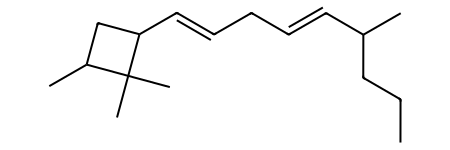

In [33]:
testmol = Chem.MolFromSmiles('CC1(C)C(C)CC1C=CCC=CC(C)CCC')
print(get_len_of_longest_linear_hydrocarbon_linker(testmol, link_unit="[#6D2R0,#8D2R0,#7D2R0]"))
testmol


13


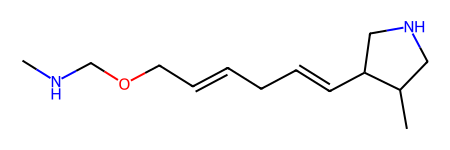

In [34]:
testmol = Chem.MolFromSmiles('CC1CNCC1C=CCC=CCOCNC')
print(get_len_of_longest_linear_hydrocarbon_linker(testmol, link_unit="[#6,#8,#7D2R0]"))
testmol

## CCD

In [35]:
ccd_df = pd.DataFrame.from_dict(ccd_dict, orient='index').reset_index()
ccd_df.columns = ['ccd_code', 'SMILES']


In [36]:
ccd_full_merged = ccd_df.merge(df_full_ccd_smiles, on='ccd_code', how='outer')
ccd_full_merged['smiles_not_in_dict'] = ccd_full_merged.SMILES.isna()
len(ccd_df), len(df_full_ccd_smiles), len(ccd_full_merged)
#TODO: inspect the missing codes!
# miss_list = missing_smiles[missing_smiles['ccd_code'].apply(lambda x: len(x.split('-')) == 1)]['ccd_code'].to_list()



(43075, 48568, 52986)

In [37]:
ccd_full_merged.head().columns

Index(['ccd_code', 'SMILES', 'system_id', 'system_pdb_id', 'joint_pocket_ID',
       'ligand_smiles', 'ligand_plip_type', 'receptor_chains_per_pdb',
       'Pfams_set', 'num_ligand_frags', 'ligand_smiles_variants',
       'split_ligand', 'ligand_smiles_unique', 'smiles_not_in_dict'],
      dtype='object')

In [38]:
# sorted(['0002', 'ss', '233'], key=len, reverse=True)

In [39]:
# fill missing with the longest smiles extracted
ccd_full_merged.loc[ccd_full_merged['smiles_not_in_dict'], 'SMILES'] = (
    ccd_full_merged.loc[ccd_full_merged['smiles_not_in_dict'], 'ligand_smiles']
    .apply(lambda x: sorted(x, key=len, reverse=True)[0])
)

In [40]:
ccd_full_merged[ccd_full_merged['SMILES'].isna()]

,ccd_code,SMILES,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,ligand_smiles_variants,split_ligand,ligand_smiles_unique,smiles_not_in_dict


In [41]:
ccd_full_merged['ROMol'] = ccd_full_merged.SMILES.apply(lambda x: Chem.MolFromSmiles(x, sanitize=False))

In [42]:
len(ccd_full_merged)

52986

In [43]:
# ccd_full_merged

In [44]:
# get heavy atom and carbon counts
carbon = Chem.MolFromSmarts("[#6]")
ccd_full_merged['numC'] = ccd_full_merged['ROMol'].progress_apply(lambda m: len(m.GetSubstructMatches(carbon)))
ccd_full_merged['numHA'] = ccd_full_merged['ROMol'].progress_apply(lambda x: x.GetNumHeavyAtoms())

# formal charge
ccd_full_merged['charge'] = ccd_full_merged['ROMol'].progress_apply(lambda mol: Chem.rdmolops.GetFormalCharge(mol))
ccd_full_merged['charge_absolute'] = ccd_full_merged['charge'].apply(lambda x: abs(x))

# get carbon linker lengths
ccd_full_merged['longest_linear_hydrocarbon_linker'] = ccd_full_merged['ROMol'].progress_apply(lambda mol: get_len_of_longest_linear_hydrocarbon_linker(mol))
ccd_full_merged['longest_unbranched_linear_linker'] = ccd_full_merged['ROMol'].progress_apply(lambda mol: get_len_of_longest_linear_hydrocarbon_linker(mol, link_unit="[#6D2R0,#8D2R0,#7D2R0,#16D2R0]"))

  0%|          | 0/52986 [00:00<?, ?it/s][10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
  3%|▎         | 1838/52986 [00:00<00:02, 18371.91it/s][10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
  7%|▋         | 3772/52986 [00:00<00:02, 18941.07it/s][10:39:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[10:39:26] WARNING: could not find number of expected ring

In [45]:
ccd_full_merged[ccd_full_merged['longest_unbranched_linear_linker'].isna()]

,ccd_code,SMILES,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,...,split_ligand,ligand_smiles_unique,smiles_not_in_dict,ROMol,numC,numHA,charge,charge_absolute,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker
1382,15P,COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCC...,"{5ohl__3__2.E__2.R, 2xpz__1__1.A__1.D, 4grh__1...","{5ail, 4mae, 1y3b, 7bbt, 3v4y, 1zd3, 1y33, 5af...","{7P26_15P_B, 4MAE_15P_E, 1Y3D_15P_K, 3B6J_15P_...","{CO/C=C\O/C=C/O/C=C\O, OCCOCCOCCOCCOCCOCCOCCOC...",{SMALLMOLECULE},"{1, 2, 3, 4, 6, 8, 12, 16}","{(PF16891, PF00149), (PF01023,), (PF01433, PF0...","{1, 2}",...,59.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xaeced2350>,69,104,0,0,2,NaN
11778,9FO,C(COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCO...,"{5zb2__1__1.A_2.A__1.I_1.K_1.L_2.I_2.K_2.L, 6v...","{6vl9, 5zb2, 7xr5}","{6VL9_9FO_E, 5ZB2_9FO_K, 7XR5_9FO_F}",{[O]CCO[CH][CH]O[CH][CH]O[CH]CO[CH][CH]O[CH][C...,{SMALLMOLECULE},"{2, 4}","{(), (PF03446, PF21761), (PF03931,)}",{1},...,3.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xaecff2f90>,40,61,0,0,2,NaN
16162,B4T,COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCC...,"{6egy__2__1.B__1.I_1.J, 6egy__1__1.A__1.F}",{6egy},"{6EGY_B4T_I, 6EGY_B4T_F, 6EGY_B4T_J}","{CCOCCOCCOCCOCC, CCOc1c2Cc3cc(cc(c3O)Cc3cc(cc(...",{SMALLMOLECULE},{2},"{(PF00034,)}",{1},...,3.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xaf1270c10>,63,100,0,0,2,NaN
21021,DKH,Cc1ccc(cc1NS(=O)(=O)C)c2cc(c3nnc(n3n2)C)NC(=O)...,"{6fic__1__1.A__1.B, 6fic__1__1.A__1.C}",{6fic},"{6FIC_DKH_C, 6FIC_DKH_B}",{NCCC(=O)Nc1cc(nn2c1nnc2C)c1ccc(c(c1)NS(=O)(=O...,{SMALLMOLECULE},{1},"{(PF00439,)}",{1},...,2.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xaf12f7ba0>,78,125,0,0,2,NaN
21290,DR6,CC(C)(C)CC(C)(C)c1ccc(cc1)OCCOCCOCCOCCOCCOCCOC...,{1ytz__1__1.A__1.D},{1ytz},{1YTZ_DR6_D},{OCCOCCOCCOCCOc1ccc(cc1)C(CC(C)(C)C)(C)C},{SMALLMOLECULE},{3},"{(PF00036, PF00992, PF13499)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xaf12ff350>,74,105,0,0,2,NaN
39125,PEU,COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCC...,"{3n7h__1__1.A__1.G, 4okh__1__1.B__1.M, 4r4k__1...","{4pl4, 2wy3, 2op3, 5xg9, 2y7p, 4ij7, 4okh, 3n7...","{6VL8_PEU_J, 5XG9_PEU_L, 4IJ7_PEU_C, 3N7H_PEU_...",{COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC...,{SMALLMOLECULE},"{1, 2, 3, 4, 8}","{(PF01395,), (), (PF00112,), (PF06479, PF00069...",{1},...,22.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xb005ee9e0>,55,83,0,0,2,NaN


In [46]:
mask = np.logical_and.reduce([
    ccd_full_merged['longest_unbranched_linear_linker'] > 12,
    ccd_full_merged['longest_linear_hydrocarbon_linker'] <= 12,
])
mask.sum()

128

In [47]:
# mols2grid.display(ccd_full_merged[mask], subset=["ccd_code", 'longest_unbranched_linear_linker', "img"],)

In [48]:
ccd_full_merged[ccd_full_merged['charge'].apply(lambda x: abs(x) >2)]

,ccd_code,SMILES,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,...,split_ligand,ligand_smiles_unique,smiles_not_in_dict,ROMol,numC,numHA,charge,charge_absolute,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker
546,0FY,Cc1cn2c(c[nH+]c2c(n1)Nc3cc(ns3)C[NH+]4CCC[C@H]...,{3vap__1__1.A__1.B},{3vap},{3VAP_0FY_B},{[C][C]1[C][C][C]N([C]1)[C]C1=NSC(=[C]1)[N]C1=...,{SMALLMOLECULE},{1},"{(PF00069,)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xaecebaf90>,27,40,3,3,1,1.0
2966,2FJ,C1=CC=[N]2C(=C1)C3=CC=CC=[N]3[Ru+2]245([N]6=C(...,{2mco__1____1.B},{2mco},{2MCO_2FJ_B},{[C]1=[C][C]=C2N([CH]1)[Ru]13(N4C2=[C][C]=[C][...,{SMALLMOLECULE},{1},{()},{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xaecefe350>,64,80,4,4,0,0.0
3053,2I2,O[W]123(O[P@@]4(=O)[O+]5[W]6(O1)(O[P@@]7(=O)[O...,{7ovs__1__1.B__1.G},{7ovs},{7OVS_2I2_G},{O=[P@@]12O[W]34(O)(O)O[W]56([O]1[W]1(O6)(O)(O...,{SMALLMOLECULE},{2},"{(PF01702,)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xaecf009e0>,0,30,4,4,0,0.0
3318,2PT,CNC(=[S][Pt+2]1[NH2]CC[NH2]1)N(C)CCNc2c3ccccc3...,{1xrw__1____1.A_1.B_1.C},{1xrw},{1XRW_2PT_C},{[C][N][C@H](N([C][C][N]C1=C2[CH][C]=[C][C]=C2...,{SMALLMOLECULE},{0},{()},{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xaecf07f90>,20,28,3,3,2,3.0
4026,3AG,CC(=CCC[N@](C)CCO[P@](=O)([O-])OP(=O)([O-])[O-])C,"{1n20__1__1.B__1.G_1.H_1.I_1.J, 1n20__1__1.A__...","{1n20, 1n21}","{1N20_3AG_F, 1N20_3AG_J, 1N21_3AG_E}","{CN(CCC=C(C)C)CCO[P@](=O)(OP(=O)([O])O)[O], CN...",{SMALLMOLECULE},"{1, 2}","{(PF03936, PF01397)}",{1},...,3.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xaecf1ba50>,9,19,-3,3,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51962,YT3,[Y+3],{4wfd__1____1.L_1.M_1.N_1.O},{4wfd},{4WFD_YT3_L},{[Y]},{SMALLMOLECULE},{7},"{(PF04000, PF08066)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xb0c853350>,0,1,3,3,0,0.0
52210,Z5A,CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=...,"{5tmp__1__1.A__1.B, 1e9a__1__1.A__1.B_1.C}","{5tmp, 1e9a}","{5TMP_Z5A_B, 1E9A_Z5A_B}",{O[C@@H]1[C@@H](CO[P@](=O)(O[P@@](=O)(OP(=O)(O...,{SMALLMOLECULE},{1},"{(PF02223,)}","{1, 2}",...,2.0,False,False,<rdkit.Chem.rdchem.Mol object at 0xb0c85a190>,20,57,-5,5,1,2.0
52357,ZCM,[Cm+3],{4zhf__1__1.A__1.G_1.H_1.I},{4zhf},{4ZHF_ZCM_G},{[Cm]},{SMALLMOLECULE},{6},"{(PF00061,)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xb0c85e2e0>,0,1,3,3,0,0.0
52740,ZR,[Zr+4],{5khp__1__1.A__1.D_1.E},{5khp},{5KHP_ZR_D},{[Zr]},{SMALLMOLECULE},{3},"{(PF00061,)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xb0c868cf0>,0,1,4,4,0,0.0


In [49]:
ccd_full_merged[ccd_full_merged['numHA'] == 0]

,ccd_code,SMILES,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,...,split_ligand,ligand_smiles_unique,smiles_not_in_dict,ROMol,numC,numHA,charge,charge_absolute,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker
19369,D8U,[2H+],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,<rdkit.Chem.rdchem.Mol object at 0xaf12c9d60>,0,0,1,1,0,0.0
21766,DUM,*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,<rdkit.Chem.rdchem.Mol object at 0xaf960c6d0>,0,0,0,0,0,0.0
27111,H,[H+],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,<rdkit.Chem.rdchem.Mol object at 0xaf96a0e40>,0,0,1,1,0,0.0
47415,UNX,*,{6c2f__1____1.S},{6c2f},{6C2F_UNX_S},{*},{SMALLMOLECULE},{18},"{(PF01429,)}",{1},...,1.0,True,False,<rdkit.Chem.rdchem.Mol object at 0xb066d4e40>,0,0,0,0,0,0.0


In [50]:
ccd_full_merged[ccd_full_merged['smiles_not_in_dict']].head(2)

,ccd_code,SMILES,system_id,system_pdb_id,joint_pocket_ID,ligand_smiles,ligand_plip_type,receptor_chains_per_pdb,Pfams_set,num_ligand_frags,...,split_ligand,ligand_smiles_unique,smiles_not_in_dict,ROMol,numC,numHA,charge,charge_absolute,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker
15,00E-DPP-ACY-LEU-PHE-02N,CC(C[C@@H](C(=O)N[C@H](C(=O)NCc1ccc(cc1)C)Cc1c...,{5cgg__1__1.K__1.CA_1.LA},{5cgg},{5CGG_00E-DPP-ACY-LEU-PHE-02N_CA},{CC(C[C@@H](C(=O)N[C@H](C(=O)NCc1ccc(cc1)C)Cc1...,{PEPTIDE},{28},"{(PF00227, PF12465, PF10584)}",{1},...,1.0,True,True,<rdkit.Chem.rdchem.Mol object at 0xaeceac430>,34,46,0,0,1,2.0
38,011-PHE-PHE,NCCCCCCC(=O)N[C@H](C(=O)N[C@H](C(=O)O)Cc1ccccc...,{8hot__1__1.A__1.C},{8hot},{8HOT_011-PHE-PHE_C},{NCCCCCCC(=O)N[C@H](C(=O)N[C@H](C(=O)O)Cc1cccc...,{PEPTIDE},{2},"{(PF00067,)}",{1},...,1.0,True,True,<rdkit.Chem.rdchem.Mol object at 0xaeceace40>,25,32,0,0,6,6.0


In [51]:
# len(ccd_full_merged[
#     np.logical_and(
#         ccd_full_merged['numHA'] == 1,
#         ccd_full_merged['numC']  == 0
#     )
# ].ccd_code.to_list())

# define ARTIFACTS

In [52]:
# # default artifacts to discard
dummy_lig_list = ['DUM', 'UNX', 'UNL', 'UNK', 'UPL', 'DN', 'N']

# # single atoms - not considered as ligands, but considered as pocket accessories if close to ligand
# skip_single_elems = Chem.MolFromSmarts("[#6,#1,#0,#7,#8,#15,#16,#34,#52]")
# single_atoms_and_ions = ccd_full_merged[
#     np.logical_and(
#         ccd_full_merged['numHA'] == 1,
#         ccd_full_merged['ROMol'].progress_apply(lambda m: len(m.GetSubstructMatches(skip_single_elems)) == 0)
#     )
# ].ccd_code.to_list()

# # phosphates -- MAYBE KEEP ARTIFACTS?
# # TODO: any else?
# # other_ions = ['PO4', '2HP', 'PI']
# # single_atoms_and_ions += other_ions

In [53]:
set('UNL-DUM-ALA'.split('-')).intersection(dummy_lig_list)
set('ALA'.split('-')).intersection(dummy_lig_list)
set('DUM'.split('-')).intersection(dummy_lig_list)

{'DUM'}

In [54]:
def assign_membership(df,
                 dummy_lig_list=['DUM', 'UNX', 'UNL', 'UNK', 'UPL', 'DN', 'N'],
                 cofactor_list = COFACTORS,
                 code_id='ccd_code'):
    
    skip_single_elems = Chem.MolFromSmarts("[#6,#1,#0,#7,#8,#15,#16,#34,#52]")
    single_atoms_and_ions = ccd_full_merged[
        np.logical_and(
            ccd_full_merged['numHA'] == 1,
            ccd_full_merged['ROMol'].progress_apply(lambda m: len(m.GetSubstructMatches(skip_single_elems)) == 0)
        )
    ].ccd_code.to_list()

    df['single_atoms_and_ions'] = df[code_id].isin(single_atoms_and_ions)
    # now dummy list includes composites, too!
    df['dummy_lig_list'] = df[code_id].apply(lambda x: len(set(x.split('-')).intersection(dummy_lig_list)) > 0)

    df['cofactor_list'] = df[code_id].isin(cofactor_list)
    # include composites?
    # df['cofactor_list'] = df[code_id].apply(lambda x: len(set(x.split('-')).difference(cofactor_list)) == 0)

    # longest co-factor 
    df['long_hydrocarbon_chains_list'] = df['longest_linear_hydrocarbon_linker'] > 12
    df['high_charged_list'] = df['charge'].apply(lambda x: abs(x) >2)

    df['default_exclusion'] = np.logical_and.reduce(
        [
            # spare single atoms from discard
            ~df['single_atoms_and_ions'],
            ~df['cofactor_list'],
            np.logical_or.reduce(
                [
                    df['high_charged_list'],
                    df['long_hydrocarbon_chains_list'],
                    df['dummy_lig_list'],
                    df['numHA'] < 5,
                    df['numC'] < 2
                ]
            )
        ]
    )
    return df 


ccd_full_merged = assign_membership(ccd_full_merged)

single_atoms_and_ions = set(ccd_full_merged.loc[ccd_full_merged['single_atoms_and_ions'], 'ccd_code'])
default_exclusions = set(ccd_full_merged.loc[ccd_full_merged['default_exclusion'], 'ccd_code'])

ccd_full_merged['default_exclusion'].sum(), len(default_exclusions), ccd_full_merged['cofactor_list'].sum(), 

100%|██████████| 52986/52986 [00:01<00:00, 50662.66it/s]


(1190, 1190, 433)

In [55]:
# ccd_full_merged[ccd_full_merged['dummy_lig_list']]

## Get stats for dynamic lists of artifacts

In [56]:
cdd_code_per_each_pdb = (
    df_full_ccd[key_cols]
    .groupby(['ccd_code', 'system_pdb_id'])[['system_id', 'receptor_chains_per_pdb', 'Pfams_set']]
    .agg({'system_id': 'count', 'receptor_chains_per_pdb': 'sum', 'Pfams_set': 'sum'})
    # .agg(list)
    .reset_index()
    .rename(columns={'system_id': 'count_per_pdbid'})
)
cdd_code_per_each_pdb

,ccd_code,system_pdb_id,count_per_pdbid,receptor_chains_per_pdb,Pfams_set
0,001,1j4r,3,9,"(PF00254, PF00254, PF00254)"
1,002,2fv9,1,2,"(PF13574,)"
2,003,2jfz,2,4,"(PF01177, PF01177)"
3,006,3fnu,4,16,"(PF00026, PF00026, PF00026, PF00026)"
4,006,3kdb,2,4,"(PF00077, PF00077)"
...,...,...,...,...,...
386080,ZZX,7jn3,2,24,"(PF00552, PF02022, PF00665, PF00552, PF02022, ..."
386081,ZZX,7ku7,2,24,"(PF00552, PF02022, PF00665, PF00552, PF02022, ..."
386082,ZZX,7kui,2,24,"(PF00552, PF00665, PF02022, PF00552, PF00665, ..."
386083,ZZY,2wd1,1,1,"(PF07714,)"


In [57]:
#TODO: test case for handling ligand and no receptor!!
#https://www.rcsb.org/structure/2g32

In [58]:
cdd_code_per_each_pdb[cdd_code_per_each_pdb.receptor_chains_per_pdb == 0]

,ccd_code,system_pdb_id,count_per_pdbid,receptor_chains_per_pdb,Pfams_set
567,0C-0C-0G-0C-0C-0U-0G-0G,1r3o,2,0,()
568,0C-0C-0G-0C-0C-0U-0G-0G,2g32,2,0,()
569,0C-0C-0G-0C-0C-0U-0G-0G,2gpm,2,0,()
570,0C-0C-0G-0C-0C-0U-0G-0G,2gq4,2,0,()
571,0C-0C-0G-0C-0C-0U-0G-0G,2gq5,2,0,()
...,...,...,...,...,...
381531,ZN,7a9r,7,0,()
381532,ZN,7a9s,7,0,()
381533,ZN,7a9t,7,0,()
382884,ZN,7ow0,3,0,()


In [59]:
cdd_code_across_pdb = cdd_code_per_each_pdb.groupby('ccd_code').agg(list).reset_index()
cdd_code_across_pdb['total_unique_pdbs'] = cdd_code_across_pdb.system_pdb_id.apply(lambda x: len(set(x)))
cdd_code_across_pdb['total_unique_Pfams'] = cdd_code_across_pdb.Pfams_set.apply(lambda x: len(set(x)))
cdd_code_across_pdb['total_count_accross_all_pdbs'] = cdd_code_across_pdb.count_per_pdbid.apply(lambda x: sum(x))
cdd_code_across_pdb['average_count_per_pdbid'] = cdd_code_across_pdb.count_per_pdbid.apply(lambda x: np.mean(x))
cdd_code_across_pdb['total_receptor_count_per_ccd'] = cdd_code_across_pdb.receptor_chains_per_pdb.apply(lambda x: sum(x))
cdd_code_across_pdb.describe()

,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd
count,48568.000000,48568.000000,48568.000000,48568.000000,4.856800e+04
mean,7.949370,3.843868,42.700461,2.560526,1.262992e+03
std,246.827487,93.822929,2113.245712,8.501076,1.367482e+05
min,1.000000,1.000000,1.000000,1.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,1.000000,2.000000e+00
50%,1.000000,1.000000,2.000000,2.000000,4.000000e+00
75%,1.000000,1.000000,4.000000,2.142857,1.000000e+01
max,25011.000000,10277.000000,362732.000000,963.034483,2.744643e+07


In [60]:
cdd_code_across_pdb['average_count_per_receptor'] = (
[nlig/nrec if nrec >0 else None for nlig, nrec in cdd_code_across_pdb[['total_count_accross_all_pdbs', 'total_receptor_count_per_ccd']].values]
)
cdd_code_across_pdb['average_count_per_Pfam'] = (
[nlig/nrec if nrec >0 else None for nlig, nrec in cdd_code_across_pdb[['total_count_accross_all_pdbs', 'total_unique_Pfams']].values]
)

cdd_code_across_pdb = cdd_code_across_pdb.drop(['Pfams_set', 'system_pdb_id', 'count_per_pdbid', 'receptor_chains_per_pdb'], axis=1)

In [61]:
cdd_code_across_pdb.describe()

,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd,average_count_per_receptor,average_count_per_Pfam
count,48568.000000,48568.000000,48568.000000,48568.000000,4.856800e+04,47520.000000,48568.000000
mean,7.949370,3.843868,42.700461,2.560526,1.262992e+03,0.612936,3.141679
std,246.827487,93.822929,2113.245712,8.501076,1.367482e+05,0.370182,10.952427
min,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000995,1.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000e+00,0.333333,1.000000
50%,1.000000,1.000000,2.000000,2.000000,4.000000e+00,0.500000,2.000000
75%,1.000000,1.000000,4.000000,2.142857,1.000000e+01,1.000000,3.000000
max,25011.000000,10277.000000,362732.000000,963.034483,2.744643e+07,25.000000,1163.666667


In [62]:
cdd_code_across_pdb[cdd_code_across_pdb.ccd_code == 'GOL']

,ccd_code,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd,average_count_per_receptor,average_count_per_Pfam
24704,GOL,22728,9562,109593,4.821938,376145,0.291358,11.461305


In [63]:
cdd_code_across_pdb[cdd_code_across_pdb['average_count_per_Pfam'] > 1].head(2)

,ccd_code,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd,average_count_per_receptor,average_count_per_Pfam
0,001,1,1,3,3.0,9,0.333333,3.0
2,003,1,1,2,2.0,4,0.500000,2.0


In [64]:
cdd_code_across_pdb[cdd_code_across_pdb['total_unique_pdbs'] > 30].__len__()

636

In [65]:
cdd_code_across_pdb[cdd_code_across_pdb['total_unique_Pfams'] > 20].__len__()

505

In [66]:
cdd_code_across_pdb.head(3)

,ccd_code,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd,average_count_per_receptor,average_count_per_Pfam
0,001,1,1,3,3.0,9,0.333333,3.0
1,002,1,1,1,1.0,2,0.500000,1.0
2,003,1,1,2,2.0,4,0.500000,2.0


In [67]:
cdd_code_across_pdb['dynamic_artifact'] = np.logical_and.reduce(
    [
        #
        cdd_code_across_pdb.total_unique_Pfams > 15,
        # TODO: MAKE THIS PER RECEPTOR CHAIN ! > 2
        cdd_code_across_pdb.average_count_per_pdbid > 1.5,
        # spare single atoms from discard
        cdd_code_across_pdb['ccd_code'].apply(lambda x: x not in single_atoms_and_ions),
        cdd_code_across_pdb['ccd_code'].apply(lambda x: x not in COFACTORS),
        cdd_code_across_pdb['ccd_code'].apply(lambda x: x not in default_exclusions)
    ]
)
cdd_code_across_pdb = cdd_code_across_pdb.merge(ccd_full_merged, on='ccd_code', how='outer')
cdd_code_across_pdb['dynamic_artifact'].sum()

385

In [68]:
# ccd_dict['000']

In [69]:
cdd_code_across_pdb.head(3)

,ccd_code,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,total_receptor_count_per_ccd,average_count_per_receptor,average_count_per_Pfam,dynamic_artifact,SMILES,...,charge,charge_absolute,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker,single_atoms_and_ions,dummy_lig_list,cofactor_list,long_hydrocarbon_chains_list,high_charged_list,default_exclusion
0,000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COC(=O)O,...,0,0,0,1.0,False,False,False,False,False,False
1,001,1.0,1.0,3.0,3.0,9.0,0.333333,3.0,False,COc1cc(cc(c1OC)OC)C(C(=O)N2CCCC[C@H]2C(=O)O[C@...,...,0,0,3,3.0,False,False,False,False,False,False
2,002,1.0,1.0,1.0,1.0,2.0,0.500000,1.0,False,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC...,...,0,0,1,1.0,False,False,False,False,False,False


In [70]:
cdd_code_across_pdb.columns

Index(['ccd_code', 'total_unique_pdbs', 'total_unique_Pfams',
       'total_count_accross_all_pdbs', 'average_count_per_pdbid',
       'total_receptor_count_per_ccd', 'average_count_per_receptor',
       'average_count_per_Pfam', 'dynamic_artifact', 'SMILES', 'system_id',
       'system_pdb_id', 'joint_pocket_ID', 'ligand_smiles', 'ligand_plip_type',
       'receptor_chains_per_pdb', 'Pfams_set', 'num_ligand_frags',
       'ligand_smiles_variants', 'split_ligand', 'ligand_smiles_unique',
       'smiles_not_in_dict', 'ROMol', 'numC', 'numHA', 'charge',
       'charge_absolute', 'longest_linear_hydrocarbon_linker',
       'longest_unbranched_linear_linker', 'single_atoms_and_ions',
       'dummy_lig_list', 'cofactor_list', 'long_hydrocarbon_chains_list',
       'high_charged_list', 'default_exclusion'],
      dtype='object')

# TODO: compare with BioLIP and RFAA, AF2

    - missing from AF2&RFAA
    - missing from BioLip
    - more than above 


In [71]:
def parse_artifacts_v2() -> set[str]:
    """Get and parse artifacts."""

    artifacts_text = requests.get(
        (
            "https://raw.githubusercontent.com/kad-ecoli/mmCIF2BioLiP/"
            + "dc9769f286eafc550f799239486ef64450728246/ligand_list"
        )
    ).text
    artifacts = set()
    for line in artifacts_text.split("\n"):
        artifacts.add(line.split("\t")[0])

    rosettafold_artifacts = {
        "NUC",
        "ZN",
        "CA",
        "MG",
        "III",
        "MN",
        "FE",
        "CU",
        "SF4",
        "FE2",
        "CO",
        "FES",
        "GOL",
        "NA",
        "CL",
        "K",
        "CU1",
        "XE",
        "NO2",
        "EDO",
        "NI",
        "BR",
        "CD",
        "O",
        "CS",
        "NO",
        "TL",
        "HG",
        "UNL",
        "KR",
        "SR",
        "RB",
        "F",
        "AG",
        "AR",
        "U",
        "AU",
        "MO",
        "SE",
        "GD",
        "YB",
        "VX",
        "SM",
        "LI",
        "RE",
        "N",
        "W",
        "OS",
        "HO",
        "PI",
        "PG4",
        "OGA",
        "SO4",
        "HEZ",
        "FEO",
        "DMS",
        "ACT",
        "MPD",
        "NH2",
        "CUA",
        "SIW",
        "PGW",
        "IOD",
        "3NI",
        "ZRW",
        "78M",
        "UNX",
        "MES",
        "CCN",
        "PO4",
    }

    alphafold_artifacts = {
        "144",
        "15P",
        "1PE",
        "2F2",
        "2JC",
        "3HR",
        "3SY",
        "7N5",
        "7PE",
        "AAE",
        "ABA",
        "ACE",
        "ACN",
        "ACT",
        "ACY",
        "AZI",
        "BAM",
        "BCN",
        "BCT",
        "BDN",
        "BEN",
        "BME",
        "BO3",
        "BTB",
        "BTC",
        "BU1",
        "C8E",
        "CAD",
        "CAQ",
        "CBM",
        "CCN",
        "CIT",
        "CL",
        "CLR",
        "CM",
        "CMO",
        "CO3",
        "CPT",
        "CXS",
        "D10",
        "DEP",
        "DIO",
        "DMS",
        "DN",
        "DOD",
        "DOX",
        "EDO",
        "EEE",
        "EGL",
        "EOH",
        "EOX",
        "EPE",
        "ETF",
        "FCY",
        "FJO",
        "FLC",
        "FMT",
        "FW5",
        "GOL",
        "GSH",
        "GTT",
        "GYF",
        "HED",
        "IHP",
        "IHS",
        "IMD",
        "IOD",
        "IPA",
        "IPH",
        "LDA",
        "MB3",
        "MEG",
        "MES",
        "MLA",
        "MLI",
        "MOH",
        "MPD",
        "MRD",
        "MSE",
        "MYR",
        "N",
        "NA",
        "NH2",
        "NH4",
        "NHE",
        "NO3",
        "O4B",
        "OHE",
        "OLA",
        "OLC",
        "OMB",
        "OME",
        "OXA",
        "P6G",
        "PE3",
        "PE4",
        "PEG",
        "PEO",
        "PEP",
        "PG0",
        "PG4",
        "PGE",
        "PGR",
        "PLM",
        "PO4",
        "POL",
        "POP",
        "PVO",
        "SAR",
        "SCN",
        "SEO",
        "SEP",
        "SIN",
        "SO4",
        "SPD",
        "SPM",
        "SR",
        "STE",
        "STO",
        "STU",
        "TAR",
        "TBU",
        "TME",
        "TPO",
        "TRS",
        "UNK",
        "UNL",
        "UNX",
        "UPL",
        "9JE",
        "URE",
    }
    return artifacts, rosettafold_artifacts, alphafold_artifacts
    # return artifacts.union(rosettafold_artifacts).union(alphafold_artifacts)

artifacts_biolip, artifacts_rosettafold, artifacts_alphafold = parse_artifacts_v2()

In [72]:
banlist = (artifacts_rosettafold.union(artifacts_alphafold).union(artifacts_biolip).union(add_as_artifacts)).difference(keep_as_not_artifacts)
len(banlist)

546

In [73]:
cdd_code_across_pdb['artifacts_biolip'] = cdd_code_across_pdb.ccd_code.isin(artifacts_biolip)
cdd_code_across_pdb['artifacts_AF2RFAA'] = cdd_code_across_pdb.ccd_code.isin(artifacts_rosettafold.union(artifacts_alphafold))
cdd_code_across_pdb['artifacts_banlist'] = cdd_code_across_pdb.ccd_code.isin(banlist)
cdd_code_across_pdb['keep_as_not_artifacts'] = cdd_code_across_pdb.ccd_code.isin(keep_as_not_artifacts)
cdd_code_across_pdb['add_as_artifacts'] = cdd_code_across_pdb.ccd_code.isin(add_as_artifacts)


In [74]:
len(artifacts_rosettafold.union(artifacts_alphafold)), len(artifacts_biolip)

(183, 464)

In [75]:
cdd_code_across_pdb.loc[cdd_code_across_pdb['artifacts_AF2RFAA'], 'ccd_code'].isin(artifacts_rosettafold.union(artifacts_alphafold)).sum(), 

(183,)

In [76]:
cdd_code_across_pdb.loc[cdd_code_across_pdb['artifacts_biolip'], 'ccd_code'].isin(artifacts_biolip).sum()

463

In [77]:
# from plinder.data.utils.annotations.rdkit_utils import fix_valency_issues

def get_qed(mol):
    try:
        qed = QED.qed(mol)
    except Exception as e:
        # print(e)
        qed = None
    return qed

from rdkit.rdBase import BlockLogs

In [78]:
# cdd_code_across_pdb.ROMol.progress_apply(sanitize_mol)
# cdd_code_across_pdb['ROMol2'] = cdd_code_across_pdb.ROMol.progress_apply(fix_valency_issues)

In [79]:
with BlockLogs():
    cdd_code_across_pdb['QED'] = cdd_code_across_pdb.ROMol.progress_apply(get_qed)

  0%|          | 134/52986 [00:00<00:39, 1339.93it/s]

100%|██████████| 52986/52986 [00:45<00:00, 1173.44it/s]


In [80]:
(cdd_code_across_pdb['QED'] < 0.3).sum()

18467

# WRITE TO INSPECT 

In [81]:
# write_cols = list(set(cdd_code_across_pdb.columns) - {'ROMol'})
# write_cols
write_cols = [
    'ccd_code',
    'SMILES',
    'artifacts_banlist',
    'dynamic_artifact',
    'total_unique_pdbs',
    'total_unique_Pfams',
    'total_count_accross_all_pdbs',
    'average_count_per_pdbid',
    'average_count_per_Pfam',
    'total_receptor_count_per_ccd',
    'average_count_per_receptor',
    'cofactor_list',
    'single_atoms_and_ions',
    'dummy_lig_list',
    'default_exclusion',
    'high_charged_list',
    'long_hydrocarbon_chains_list',
    'charge',
    'charge_absolute',
    'numHA',
    'numC',
    'longest_linear_hydrocarbon_linker',
    'longest_unbranched_linear_linker',
    'system_pdb_id',
    'ligand_smiles_variants',
    'split_ligand',
    'ligand_smiles_unique',
    'smiles_not_in_dict',
    'artifacts_biolip',
    'artifacts_AF2RFAA',
    'QED'
 ]

In [82]:
cdd_code_across_pdb[write_cols]

,ccd_code,SMILES,artifacts_banlist,dynamic_artifact,total_unique_pdbs,total_unique_Pfams,total_count_accross_all_pdbs,average_count_per_pdbid,average_count_per_Pfam,total_receptor_count_per_ccd,...,longest_linear_hydrocarbon_linker,longest_unbranched_linear_linker,system_pdb_id,ligand_smiles_variants,split_ligand,ligand_smiles_unique,smiles_not_in_dict,artifacts_biolip,artifacts_AF2RFAA,QED
0,000,COC(=O)O,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,NaN,NaN,NaN,NaN,False,False,False,0.422195
1,001,COc1cc(cc(c1OC)OC)C(C(=O)N2CCCC[C@H]2C(=O)O[C@...,False,False,1.0,1.0,3.0,3.0,3.000000,9.0,...,3,3.0,{1j4r},1.0,1.0,True,False,False,False,0.177625
2,002,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC...,False,False,1.0,1.0,1.0,1.0,1.000000,2.0,...,1,1.0,{2fv9},1.0,1.0,True,False,False,False,0.229670
3,003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,False,False,1.0,1.0,2.0,2.0,2.000000,4.0,...,1,1.0,{2jfz},1.0,1.0,True,False,False,False,0.417322
4,004,c1ccc(cc1)[C@@H](C(=O)O)N,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,NaN,NaN,NaN,NaN,False,False,False,0.655800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52981,ZZV,C[N@@](c1c2cccnc2c(c3c1CN(C3=O)Cc4ccc(cc4)F)O)...,False,False,1.0,1.0,2.0,2.0,2.000000,8.0,...,1,1.0,{3oyd},1.0,1.0,True,False,False,False,0.707475
52982,ZZW,c1ccc2c(c1)c3cc(ncc3n2Cc4ccc(cc4)F)C(=O)NO,False,False,1.0,1.0,2.0,2.0,2.000000,8.0,...,1,1.0,{3oyc},1.0,1.0,True,False,False,False,0.444745
52983,ZZX,CCN1C[C@@H](n2c3c(c(c2C1=O)O)C(=O)N(N=C3C(=O)N...,False,False,7.0,3.0,14.0,2.0,4.666667,104.0,...,1,1.0,"{3oyb, 7jn3, 3oyl, 7kui, 3oyn, 3oyj, 7ku7}",9.0,9.0,False,False,False,False,0.618327
52984,ZZY,c1ccc(c(c1)[N+](=O)[O-])S(=O)(=O)n2ccc3c2cc(cn...,False,False,1.0,1.0,1.0,1.0,1.000000,1.0,...,0,0.0,{2wd1},1.0,1.0,True,False,False,False,0.557543


In [83]:
# cdd_code_across_pdb[write_cols].to_csv('/Users/vladas/Projects/test_dump/artifacts/vladas_artifacts_revnew_inspect2.csv', index=False)

In [84]:
# break

In [85]:
np.logical_and.reduce(
    [
        # spare single atoms from discard
        ~cdd_code_across_pdb['single_atoms_and_ions'],
        ~cdd_code_across_pdb['cofactor_list'],
        np.logical_or.reduce(
            [
                # cdd_code_across_pdb['charge_absolute'] > 2,
                cdd_code_across_pdb['longest_linear_hydrocarbon_linker'] > 12,
                # cdd_code_across_pdb['numHA'] < 5,
                # cdd_code_across_pdbdf['numC'] < 2
            ]
        )
    ]
).sum()

511

In [86]:
mask = np.logical_and.reduce(
    [
        # spare single atoms from discard
        # ~cdd_code_across_pdb['single_atoms_and_ions'],
        # ~cdd_code_across_pdb['cofactor_list'],
        np.logical_or.reduce(
            [
                # cdd_code_across_pdb['charge_absolute'] > 2,
                # cdd_code_across_pdb['longest_linear_hydrocarbon_linker'] > 12,
                cdd_code_across_pdb['default_exclusion'],
                # cdd_code_across_pdb['numHA'] < 5,
                # cdd_code_across_pdb['numC'] < 2,
                # cdd_code_across_pdb['dynamic_artifact'],
                # np.logical_and(
                #     cdd_code_across_pdb.total_unique_Pfams > 20,
                #     cdd_code_across_pdb.average_count_per_pdbid > 1.5
                # )

            ]
        )
    ]
)
mask.sum()

1190

In [87]:
cdd_code_across_pdb['single_atoms_and_ions'].sum()

93

In [88]:
af2rfaa = artifacts_rosettafold.union(artifacts_alphafold)
len(af2rfaa)

183

In [89]:
# af2rfaa

In [90]:
len(artifacts_biolip)

464

In [91]:
len(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']).intersection(artifacts_biolip).intersection(af2rfaa))

31

In [92]:
len(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']).difference(artifacts_biolip).difference(af2rfaa))

990

In [93]:
len(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']).intersection(artifacts_biolip.union(af2rfaa)))

200

In [94]:
len(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']).intersection(af2rfaa))

64

In [95]:
new_filter_exclusions = set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']).difference(artifacts_biolip).difference(af2rfaa)
cdd_code_across_pdb['new_filter_exclusions'] = cdd_code_across_pdb.ccd_code.isin(new_filter_exclusions)

In [96]:
new_dynamic_exclusions = set(cdd_code_across_pdb.loc[cdd_code_across_pdb['dynamic_artifact'].fillna(False), 'ccd_code']).difference(artifacts_biolip).difference(af2rfaa)
print(len(new_dynamic_exclusions))
cdd_code_across_pdb['new_dynamic_exclusions'] = cdd_code_across_pdb.ccd_code.isin(new_dynamic_exclusions)

252


/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/3014795403.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_dynamic_exclusions = set(cdd_code_across_pdb.loc[cdd_code_across_pdb['dynamic_artifact'].fillna(False), 'ccd_code']).difference(artifacts_biolip).difference(af2rfaa)


In [97]:
artifacts_bar = artifacts_biolip.union(af2rfaa)
# artifacts_bar
len(artifacts_bar)

544

In [98]:
artifacts_bar.difference(cdd_code_across_pdb.ccd_code)

{''}

In [99]:
our_new = set(cdd_code_across_pdb.loc[cdd_code_across_pdb['dynamic_artifact'].fillna(False), 'ccd_code']).union(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']))

/var/folders/8s/zn7mks316fz42nd48972whrh0000gn/T/ipykernel_10545/1865119196.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  our_new = set(cdd_code_across_pdb.loc[cdd_code_across_pdb['dynamic_artifact'].fillna(False), 'ccd_code']).union(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']))


In [100]:
len(our_new)

1575

In [101]:
len(af2rfaa.difference(our_new)),  len(artifacts_biolip.difference(our_new)),  len(artifacts_bar.difference(our_new))

(70, 172, 211)

In [102]:
cdd_code_across_pdb['old_artifacts_missed_in_ours'] = cdd_code_across_pdb.ccd_code.isin(artifacts_bar.difference(our_new))

In [103]:
cdd_code_across_pdb['old_artifacts_missed_by_defaults'] = cdd_code_across_pdb.ccd_code.isin(artifacts_bar.difference(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code'])))

cdd_code_across_pdb['badlist_artifacts_used'] = cdd_code_across_pdb.ccd_code.isin(
    (
        set(cdd_code_across_pdb.loc[cdd_code_across_pdb['artifacts_banlist'], 'ccd_code'])
        .difference(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['default_exclusion'], 'ccd_code']))
    )
    .difference(
        set(cdd_code_across_pdb.loc[cdd_code_across_pdb['single_atoms_and_ions'], 'ccd_code'])
        .union(set(cdd_code_across_pdb.loc[cdd_code_across_pdb['cofactor_list'], 'ccd_code']))
    )
)


In [104]:
cdd_code_across_pdb['badlist_artifacts_used'].sum()

276

In [105]:
artifacts_bar.difference(cdd_code_across_pdb.ccd_code)

{''}

In [106]:
write_cols2 = write_cols + ['new_filter_exclusions', 'new_dynamic_exclusions','old_artifacts_missed_in_ours', 'old_artifacts_missed_by_defaults', 'badlist_artifacts_used']

In [107]:
cdd_code_across_pdb[write_cols2].to_csv('/Users/vladas/Projects/test_dump/artifacts/vladas_artifacts_revnew_inspect_Apr22_final.csv', index=False)

In [109]:
import mols2grid

In [1]:
# mask = np.logical_and.reduce([
#     cdd_code_across_pdb['longest_unbranched_linear_linker'] > 12,
#     cdd_code_across_pdb['longest_linear_hydrocarbon_linker'] <= 12,
# ])

In [124]:
grid = mols2grid.MolGrid(
    cdd_code_across_pdb[cdd_code_across_pdb['badlist_artifacts_used']],
    molCol='ROMol',
    subset=["ccd_code", "img", 'total_unique_pdbs'],
    )

MolGridWidget()

In [131]:
grid.save('/Users/vladas/Projects/test_dump/artifacts/vladas_artifacts_revnew_inspect_Apr22_remove.html',
subset=["ccd_code", "img", 'total_unique_pdbs'],
n_items_per_page=48)

In [129]:
grid.display(
    # set what's displayed on the grid
    # subset=["ccd_code", "img", 'total_unique_pdbs'],
    n_items_per_page=12
)

In [136]:
new_ones = np.logical_or.reduce([
    cdd_code_across_pdb['add_as_artifacts'],
    cdd_code_across_pdb['new_filter_exclusions'],
])

In [139]:
sum(new_ones)

1027

In [137]:
gridnew = mols2grid.MolGrid(
    cdd_code_across_pdb[new_ones],
    molCol='ROMol',
    subset=["ccd_code", "img", 'total_unique_pdbs'],
)

MolGridWidget()

In [140]:
gridnew.save('/Users/vladas/Projects/test_dump/artifacts/vladas_artifacts_revnew_inspect_Apr22_removed_new.html',
subset=["ccd_code", "img", 'total_unique_pdbs'],
n_items_per_page=48)

In [ ]:
break

## get ccd ref

In [ ]:
# df_ligs = pd.read_csv('~/Projects/test_dump/ligands_profile.csv')
# df_ligs.head()

In [ ]:
# df_ligs.insert(2, 'ARTIFACT', df_ligs.ligand_ccd_code.apply(lambda x: x in artifacts))


In [ ]:
# sum(df_ligs['ARTIFACT'])

356

In [ ]:
# gem = load_ccd_via_gemmi(Path('/Users/vladas/Projects/test_dump'))

In [ ]:
ccd_df = pd.DataFrame.from_dict(ccd_dict, orient='index').reset_index()
ccd_df.columns = ['ligand_ccd_code', 'SMILES']
ccd_df.SMILES = ccd_df.SMILES.apply(lambda x: x.strip('"').strip(';'))

# artifacts_biolip, rosettafold_artifacts, alphafold_artifacts
ccd_df['artifact_BioLIP'] = ccd_df.ligand_ccd_code.apply(lambda x: x in artifacts_biolip)
ccd_df['artifact_RFAA'] = ccd_df.ligand_ccd_code.apply(lambda x: x in rosettafold_artifacts)
ccd_df['artifact_AF2'] = ccd_df.ligand_ccd_code.apply(lambda x: x in alphafold_artifacts)

ccd_df.head()

,ligand_ccd_code,SMILES,artifact_BioLIP,artifact_RFAA,artifact_AF2
0,000,COC(=O)O,False,False,False
1,001,COc1cc(cc(c1OC)OC)C(C(=O)N2CCCC[C@H]2C(=O)O[C@...,False,False,False
2,002,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)O)NC...,False,False,False
3,003,CC(C)CN1c2c(c(n(n2)Cc3cccc4c3cccc4)c5ccncc5)C(...,False,False,False
4,004,c1ccc(cc1)[C@@H](C(=O)O)N,False,False,False


In [ ]:
ccd_df.to_csv('/Users/vladas/Projects/test_dump/artifacts/all_ccds.csv')

In [ ]:
artlist = [{"ligand_ccd_code": a, "SMILES": ccd_dict[a].strip('"')} for a in artifacts if a not in ['UNL']]

In [ ]:
artdf = pd.DataFrame(artlist)
artdf

,ligand_ccd_code,SMILES
0,SCN,C(#N)[S-]
1,FMT,C(=O)O
2,PG0,COCCOCCO
3,HEZ,C(CCCO)CCO
4,MYS,CCCCCCCCCCCCCCC
...,...,...
537,DKA,CCCCCCCCCC(=O)O
538,EAP,C(=COP(=O)(O)O)N
539,MO6,[OH2][Mg+2]([OH2])([OH2])([OH2])([OH2])[OH2]
540,SPW,[2H][N+]([2H])([2H])CCC[N+]([2H])([2H])CCCC[N+...


In [ ]:
artdf.to_csv('/Users/vladas/Projects/test_dump/artifacts/current_artifacts_542.csv')

## other

In [ ]:
# %pip install seaborn

In [ ]:
df_rfaa_ligs = pd.read_json('/Users/vladas/plinder_local_data/RFAA_ligands.json')

In [ ]:
len(df_rfaa_ligs)

In [ ]:
with open('/Users/vladas/plinder_local_data/RFAA_ligands.sdf') as o:
    for l in df_rfaa_ligs.loc['sdf'].values:
        o.write(l + '\n')

In [ ]:
df1 = pdt.LoadSDF('/Users/vladas/plinder_local_data/RFAA_ligands.sdf')

In [ ]:
df1

In [ ]:
df_rfaa_ligs.sdf

In [ ]:
df_rfaa_ligs['ROMol'] = df_rfaa_ligs.sdf.apply(Chem.MolFromMolBlock)


In [ ]:
df_rfaa_ligs['SMILES'] = df_rfaa_ligs.ROMol.apply(Chem.MolToSmiles)

In [ ]:
import datamol as dm

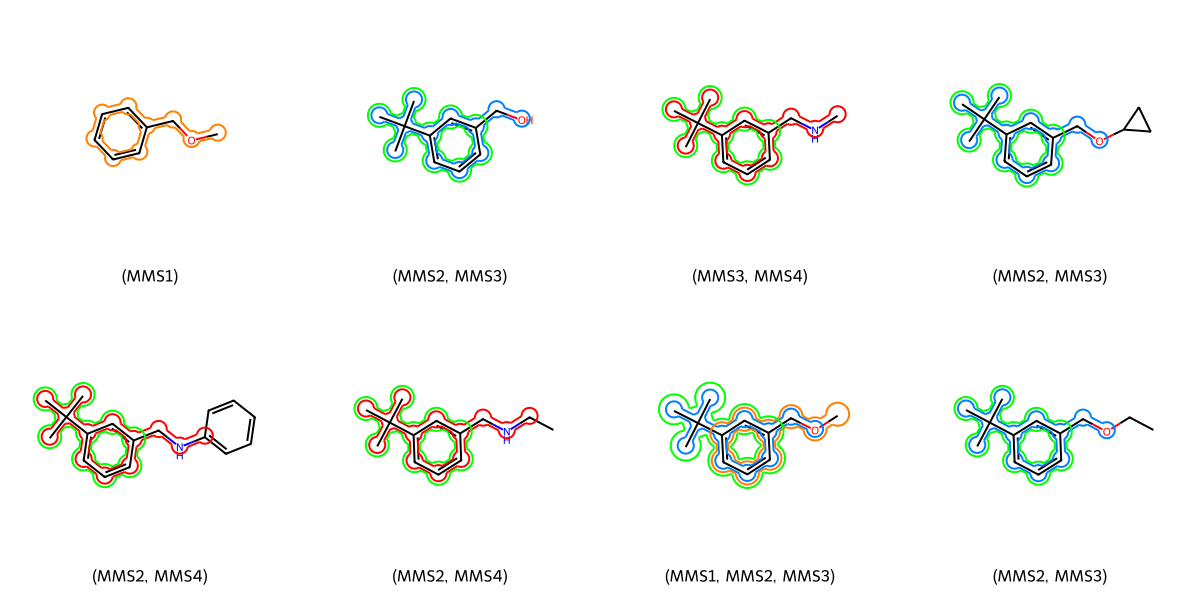

In [ ]:
smis = 'C1C=CC(COC)=CC=1.C1C(C(C)(C)C)=CC(CO)=CC=1.C1C(C(C)(C)C)=CC(CNC)=CC=1.C1C(C(C)(C)C)=CC(COC2CC2)=CC=1.C1C(C(C)(C)C)=CC(CN(c2ccccc2))=CC=1.C1C(C(C)(C)C)=CC(CNCC)=CC=1.C1C(C(C)(C)C)=CC(COC)=CC=1.C1C(C(C)(C)C)=CC(COCC)=CC=1'\
    .split('.')
smarts_list = ["c1ccc(C(C)(C)(C))cc1(CN[#6])", "c1ccc(C(C)(C)(C))cc1(C[O])", "c1[c]c[ch1]cc1(CO[Ch3])", "c1ccccc1(C(C)(C)(C))"]

dm.lasso_highlight_image(smis,
                smarts_list,
                draw_mols_same_scale=True,
                legends=['(MMS1)', '(MMS2, MMS3)', '(MMS3, MMS4)', '(MMS2, MMS3)',
                        '(MMS2, MMS4)', '(MMS2, MMS4)', '(MMS1, MMS2, MMS3)', '(MMS2, MMS3)'
                        ],
                use_svg=False)